In [1]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
import cv2

In [3]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
from rafdb_dataset import RAFDBDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    # transforms.RandomHorizontalFlip(), 
    # transforms.RandomApply([
    #     transforms.RandomRotation(5),
    #     transforms.RandomCrop(64, padding=8)
    # ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
rafdb_dataset_train = RAFDBDataset(csv_file='archive/train_labels.csv',
                            img_dir='archive/DATASET/train/',
                            transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = RAFDBDataset(csv_file='dataset/vali_labels.csv',
                            img_dir='dataset/validation_set',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

rafdb_dataset_test = RAFDBDataset(csv_file='archive/test_labels.csv',
                            img_dir='archive/DATASET/test',
                            transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [5]:
# for images, labels in data_train_loader:
#     labels = labels - 1
#     if labels.min() < 0 or labels.max() > 5:
#         print("Found label outside the expected range [0, 5]")
#         break

# for images, labels in data_vali_loader:
#     labels = labels - 1
#     if labels.min() < 0 or labels.max() > 5:
#         print("Found label outside the expected range [0, 5]")
#         break

# for images, labels in data_test_loader:
#     labels = labels - 1
#     if labels.min() < 0 or labels.max() > 5:
#         print("Found label outside the expected range [0, 5]")
#         break


In [6]:
class SEBlock(nn.Module): # Squeeze-and-Excitation (SE) blocks apply channel-wise attention.
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_channels, input_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_channels // reduction, input_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out

In [8]:
# Residual 
# class EmotionClassifier(nn.Module):
#     def __init__(self):
#         super(EmotionClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.se1 = SEBlock(64)

#         # Using Residual Blocks
#         self.res_block1 = ResidualBlock(64, 128, stride=2)
#         self.res_block2 = ResidualBlock(128, 256, stride=2)
#         self.res_block3 = ResidualBlock(256, 512, stride=2)
#         self.res_block4 = ResidualBlock(512, 1024, stride=2)

#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(1024, 2048)
#         self.fc2 = nn.Linear(2048, 1024) 
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(1024, 6)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.se1(x)
        
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
        
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# model = EmotionClassifier().to(device)

In [9]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # self.se1 = SEBlock(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        # the Grad-CAM hook is to be added after self.bn5
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 1024) 
        self.dropout1 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 6)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        # x = self.se1(x)
        # x = F.relu(self.se1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = EmotionClassifier().to(device)

In [10]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion * planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=6):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out

# def EmotionClassifierResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

# model = EmotionClassifierResNet18().to(device)


In [11]:
# import torch.nn as nn
# import torch.nn.functional as F

# class VGGEmotionClassifier(nn.Module):
#     def __init__(self):
#         super(VGGEmotionClassifier, self).__init__()
        
#         self.features = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(16384, 4096), 
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 1024),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(1024, 6)  
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

# model = VGGEmotionClassifier().to(device)

In [12]:
# param_grid = {
#     'lr': [0.1, 0.01, 0.001, 0.0001], 
#     'batch_size': [8, 16, 32, 64],  
# }
# grid = ParameterGrid(param_grid)
# results = []

In [13]:
# for params in grid: # Hyperparameter tuning 
#     data_train_loader = DataLoader(rafdb_dataset_train, batch_size=params['batch_size'], shuffle=True, num_workers=4)
#     data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=params['batch_size'], shuffle=False, num_workers=0)
    
#     model = EmotionClassifier().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=params['lr'])
#     criterion = nn.CrossEntropyLoss()
    
#     best_val_acc = 0
#     num_epochs = 15
    
#     for epoch in range(num_epochs):
#         model.train()
#         for i, data in enumerate(tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 0):
#             inputs, labels = data[0].to(device), data[1].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for data in data_vali_loader:
#             inputs, labels = data[0].to(device), data[1].to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()
    
#     val_acc = val_correct / val_total
#     best_val_acc = max(best_val_acc, val_acc)
    
#     results.append({
#         'lr': params['lr'],
#         'batch_size': params['batch_size'],
#         'best_val_acc': best_val_acc,
#     })

# for result in results:
#     print(f"LR: {result['lr']}, Batch Size: {result['batch_size']}, Best Val Acc: {result['best_val_acc']}")

# best_params = max(results, key=lambda x: x['best_val_acc'])
# print(f"Best params: {best_params}")

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # test 5/0.5 later

patience = 5
best_val_acc = 0  
patience_counter = 0

num_epochs = 40

In [15]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_vgg.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/40: 100%|██████████| 2127/2127 [04:31<00:00,  7.84it/s]


Epoch 1, Train Loss: 1.0731483176245509, Train Accuracy: 0.42691313036323025, Test Loss: 0.9934714935223261, Test Accuracy: 0.6046901172529313, Validation Loss: 1.2384678219494067, Validation Accuracy: 0.31552587646076796


Epoch 2/40: 100%|██████████| 2127/2127 [04:26<00:00,  7.98it/s]


Epoch 2, Train Loss: 0.8131816883741773, Train Accuracy: 0.5499294698483602, Test Loss: 0.7218782230218251, Test Accuracy: 0.7077051926298158, Validation Loss: 1.050280944297188, Validation Accuracy: 0.4090150250417362


Epoch 3/40: 100%|██████████| 2127/2127 [04:26<00:00,  7.99it/s]


Epoch 3, Train Loss: 0.7085798778722249, Train Accuracy: 0.5877218761020336, Test Loss: 0.6489569030205409, Test Accuracy: 0.7382747068676717, Validation Loss: 1.0203172439023067, Validation Accuracy: 0.41736227045075125


Epoch 4/40: 100%|██████████| 2127/2127 [04:25<00:00,  8.00it/s]


Epoch 4, Train Loss: 0.6316595696714993, Train Accuracy: 0.6159045491947808, Test Loss: 0.5455777803063393, Test Accuracy: 0.7554438860971524, Validation Loss: 0.9325464132585024, Validation Accuracy: 0.4307178631051753


Epoch 5/40: 100%|██████████| 2127/2127 [04:26<00:00,  7.99it/s]


Epoch 5, Train Loss: 0.5575515696026655, Train Accuracy: 0.6421476431174327, Test Loss: 0.5930802835027377, Test Accuracy: 0.7378559463986599, Validation Loss: 0.8506904385591808, Validation Accuracy: 0.5191986644407346


Epoch 6/40: 100%|██████████| 2127/2127 [04:25<00:00,  8.00it/s]


Epoch 6, Train Loss: 0.4913038342042209, Train Accuracy: 0.6698013400728812, Test Loss: 0.4909075144430002, Test Accuracy: 0.7747068676716918, Validation Loss: 0.8349992726978502, Validation Accuracy: 0.5158597662771286
No improvement in validation accuracy for 1 epochs.


Epoch 7/40: 100%|██████████| 2127/2127 [34:22<00:00,  1.03it/s]


Epoch 7, Train Loss: 0.418302821548026, Train Accuracy: 0.7007758316680381, Test Loss: 0.547809486190478, Test Accuracy: 0.7587939698492462, Validation Loss: 0.9373903086310938, Validation Accuracy: 0.48914858096828046
No improvement in validation accuracy for 2 epochs.


Epoch 8/40: 100%|██████████| 2127/2127 [1:02:35<00:00,  1.77s/it]  


Epoch 8, Train Loss: 0.5648140813770026, Train Accuracy: 0.6569883625249794, Test Loss: 0.5696586355039229, Test Accuracy: 0.7763819095477387, Validation Loss: 0.9298893864217558, Validation Accuracy: 0.5792988313856428


Epoch 9/40: 100%|██████████| 2127/2127 [04:26<00:00,  7.99it/s]


Epoch 9, Train Loss: 0.32385791029731187, Train Accuracy: 0.7417127071823204, Test Loss: 0.7012892266145597, Test Accuracy: 0.7629815745393634, Validation Loss: 1.1724764920378987, Validation Accuracy: 0.5659432387312187
No improvement in validation accuracy for 1 epochs.


Epoch 10/40: 100%|██████████| 2127/2127 [04:26<00:00,  7.97it/s]


Epoch 10, Train Loss: 0.2567910637197947, Train Accuracy: 0.769483954390502, Test Loss: 0.6306526613545914, Test Accuracy: 0.7780569514237856, Validation Loss: 1.2123915866801613, Validation Accuracy: 0.5525876460767947
No improvement in validation accuracy for 2 epochs.


Epoch 11/40: 100%|██████████| 2127/2127 [04:25<00:00,  8.00it/s]


Epoch 11, Train Loss: 0.18745878749310516, Train Accuracy: 0.7922299282943458, Test Loss: 0.7630096973894008, Test Accuracy: 0.7784757118927973, Validation Loss: 1.4635402983740757, Validation Accuracy: 0.5692821368948247
No improvement in validation accuracy for 3 epochs.


Epoch 12/40: 100%|██████████| 2127/2127 [04:26<00:00,  8.00it/s]


Epoch 12, Train Loss: 0.16778852043392592, Train Accuracy: 0.8031033266721523, Test Loss: 0.7115550340293461, Test Accuracy: 0.7654941373534339, Validation Loss: 1.1243916655841626, Validation Accuracy: 0.5809682804674458


Epoch 13/40: 100%|██████████| 2127/2127 [04:26<00:00,  7.98it/s]


Epoch 13, Train Loss: 0.13189819169656958, Train Accuracy: 0.8157693664041378, Test Loss: 0.743079757890664, Test Accuracy: 0.7826633165829145, Validation Loss: 1.2989575478591417, Validation Accuracy: 0.5859766277128547


Epoch 14/40: 100%|██████████| 2127/2127 [04:26<00:00,  7.99it/s]


Epoch 14, Train Loss: 0.11338502171204856, Train Accuracy: 0.8219407546726225, Test Loss: 0.8435343292014053, Test Accuracy: 0.7734505862646566, Validation Loss: 1.5620671416583813, Validation Accuracy: 0.5709515859766278
No improvement in validation accuracy for 1 epochs.


Epoch 15/40: 100%|██████████| 2127/2127 [1:39:39<00:00,  2.81s/it]    


Epoch 15, Train Loss: 0.16976075641969124, Train Accuracy: 0.8025449629716704, Test Loss: 0.8529168379108402, Test Accuracy: 0.7801507537688442, Validation Loss: 1.5484017700349029, Validation Accuracy: 0.5893155258764607


Epoch 16/40: 100%|██████████| 2127/2127 [1:50:29<00:00,  3.12s/it]    


Epoch 16, Train Loss: 1126.2529261399202, Train Accuracy: 0.5112554366991889, Test Loss: 1.2638994216918946, Test Accuracy: 0.4962311557788945, Validation Loss: 1.5413887814471596, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 1 epochs.


Epoch 17/40: 100%|██████████| 2127/2127 [1:53:41<00:00,  3.21s/it]    


Epoch 17, Train Loss: 1.219967426018475, Train Accuracy: 0.35547196426472316, Test Loss: 1.2612911367416382, Test Accuracy: 0.4962311557788945, Validation Loss: 1.5200863511938798, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 2 epochs.


Epoch 18/40: 100%|██████████| 2127/2127 [2:26:16<00:00,  4.13s/it]    


Epoch 18, Train Loss: 1.2193024110558675, Train Accuracy: 0.35547196426472316, Test Loss: 1.288317616780599, Test Accuracy: 0.4962311557788945, Validation Loss: 1.5297436557318036, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 3 epochs.


Epoch 19/40: 100%|██████████| 2127/2127 [1:53:20<00:00,  3.20s/it]    


Epoch 19, Train Loss: 1.2191175285728537, Train Accuracy: 0.35547196426472316, Test Loss: 1.262915787299474, Test Accuracy: 0.4962311557788945, Validation Loss: 1.4968401507327431, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 4 epochs.


Epoch 20/40: 100%|██████████| 2127/2127 [1:52:33<00:00,  3.18s/it]    


Epoch 20, Train Loss: 1.2193345355494347, Train Accuracy: 0.35547196426472316, Test Loss: 1.2670828950405122, Test Accuracy: 0.4962311557788945, Validation Loss: 1.5206079106581838, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 5 epochs.


Epoch 21/40: 100%|██████████| 2127/2127 [04:28<00:00,  7.94it/s]


Epoch 21, Train Loss: 1.2195141638283669, Train Accuracy: 0.35547196426472316, Test Loss: 1.2643802650769551, Test Accuracy: 0.4962311557788945, Validation Loss: 1.5166466361597966, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 6 epochs.
Stopping early due to lack of improvement in validation accuracy.


In [16]:
# to produce pickle file, as input
# for Script from Tanja
# file_name = date_model.pkl
import pickle
import datetime

model_name = type(model).__name__

# create string with date and time to be used in file_name with hh:mm format
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H:%M")

model_file_name = formatted_datetime + '_' + model_name + '.pkl'

with open(model_file_name, 'wb') as file:
    pickle.dump(model, file)

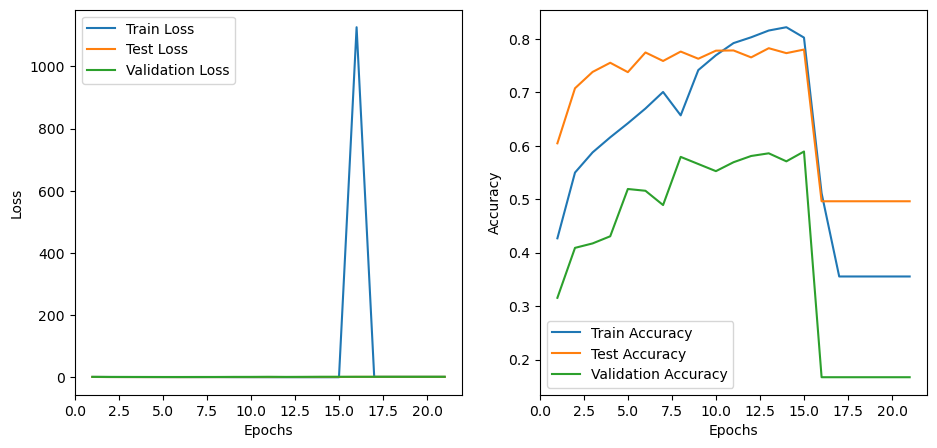

In [18]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, 22), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 22), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 22), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.title('Losses')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 22), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 22), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 22), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.title('Accuracies')
plt.legend()

plt.show()

In [19]:
df = pd.DataFrame({
    'Epoch': range(1, 22), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('training_metrics.csv', index=False)

In [20]:
# draft code: Grad-CAM
# https://medium.com/the-owl/gradcam-in-pytorch-7b700caa79e5
# compute Gradient Class Activation Maps
out, acts = gcmodel(inpimg)

acts = acts.detach().cpu() # cpu?

loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array([600])).to(‘cuda:0’))
loss.backward()

grads = gcmodel.get_act_grads().detach().cpu()

pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu() # cpu?

for i in range(acts.shape[1]):
    acts[:,i,:,:] *= pooled_grads[i]
    
heatmap_j = torch.mean(acts, dim = 1).squeeze()

heatmap_j_max = heatmap_j.max(axis = 0)[0]

heatmap_j /= heatmap_j_max

# Resize Heatmap
heatmap_j = resize(heatmap_j,(224,224),preserve_range=True)

# Colour Mapping
cmap = mpl.cm.get_cmap(‘jet’,256)
heatmap_j2 = cmap(heatmap_j,alpha = 0.2)

# Plotting
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow((img*std+mean)[0].transpose(1,2,0))
axs.imshow(heatmap_j2)
plt.show()

SyntaxError: invalid character '‘' (U+2018) (2821145960.py, line 8)

In [ ]:
# draft code: bounding box
import cv2
import matplotlib.patches as patches

heatmap_max = np.max(heatmap) # heatmap from CAM / Grad-CAM
print("Max of heatmap: %.2f" % heatmap_max)

boundary = heatmap_max * 0.3
print("Cut-off value: %.2f" % boundary)

bbox_heatmap = heatmap.copy()
bbox_heatmap = np.where(bbox_heatmap <= boundary, 0, 255)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # must have?

bbox_img = img.copy()

# find contours of heatmap
cnts = cv2.findContours(bbox_heatmap.astype('uint8'),
                        cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

offset = 10
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(bbox_img, (x+offset, y+offset),
                  (x+offset + w, y + h), (100,255,0), 30)

plt.figure(figsize=(10,10))
plt.imshow(bbox_img)
plt.title(f'{label} with confidence {conf*100:.2f}%')
plt.axis('off')
plt.savefig('./images/detection.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'np' is not defined